In [1]:
import pickle
import copy
from collections import defaultdict
import torch
import numpy as np
from BENK import TNWDataGenerator, TNW, train_model, device, make_train_set, make_spec_set, tau_loss
from learners import TValLearner, SValLearner, XValLearner
from models import NWSurv, MyCox, MySurvForest, sf_to_t
from funcs import log_func, pow_func, spiral_func, response_func
from pytorch_survival import arrs_to_torch_dev, table_exp
from sksurv.ensemble import RandomSurvivalForest
import matplotlib.pyplot as plt

np.seterr(all='ignore')
np.random.seed(123)
torch.manual_seed(123)

# The example of making the survival function prediction

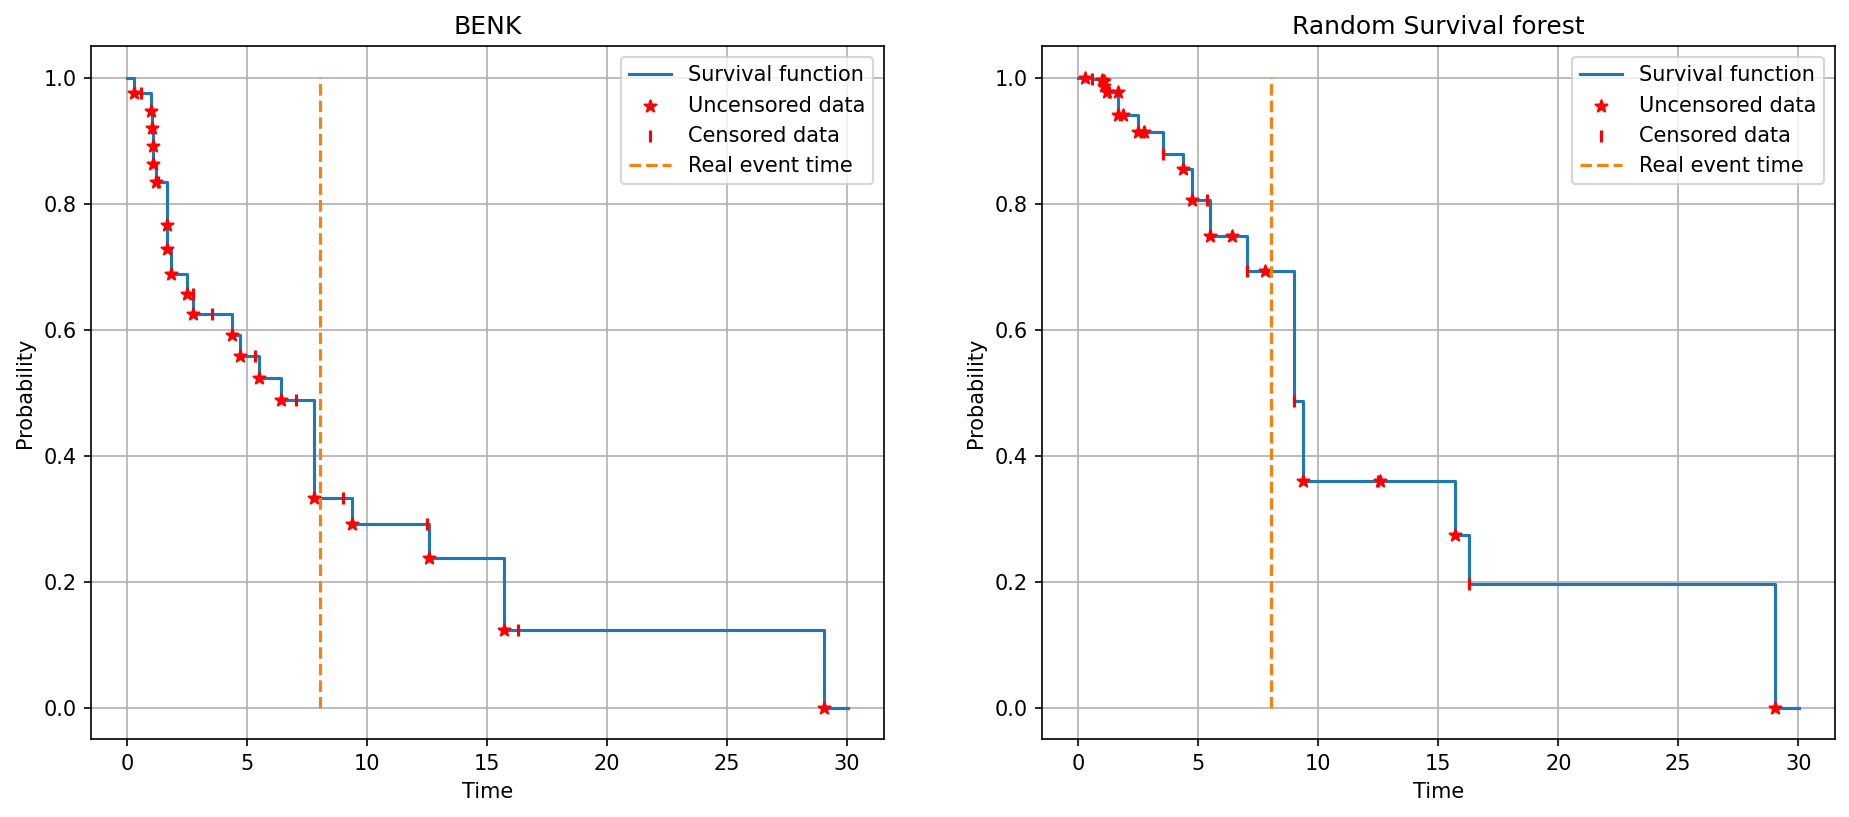

Real event time:  8.0261
BENK predicted expected event time:  8.9413  diff:  0.9152
RSF predicted expected event time:  12.6698  diff:  4.6437


In [2]:
feat_num = 20
func = spiral_func(feat_num, 0.5, 0.1, 0.02, 1)
train_size = 30
n = int(0.8 * train_size)
epochs = 100
benk = TNW(feat_num)
r = np.random.uniform(0, 10, train_size)
x_train = func.calc_x(r)
T_train = func.calc_y(r)
delta_train = np.random.binomial(1, 0.6, train_size)
sorted_args = np.argsort(T_train)
delta_sorted = delta_train[sorted_args]
censored_sorted_mask = np.concatenate(([False], delta_sorted == 0, [False]))
uncensored_sorted_mask = np.concatenate(([False], delta_sorted == 1, [False]))
T_predict = np.concatenate(([0], T_train[sorted_args], [T_train.max() + 1]))

weights = copy.deepcopy(benk.state_dict())
cur_patience = 0

benk.train()
data_generator = TNWDataGenerator(x_train, T_train, delta_train, 64, n, 2)
optimizer = torch.optim.Adagrad(benk.parameters(), 0.01)
for e in range(0, epochs):
    cur_loss = 0
    dataloader = data_generator.get_data_loader()
    steps = len(dataloader)
    for data, t_labels, d_labels in dataloader:
        optimizer.zero_grad()
        pred = benk(*data)
        loss = tau_loss(pred, t_labels)
        loss.backward()
        for p in benk.parameters():
            p.grad[torch.logical_not(torch.isfinite(p.grad))] = 0
        optimizer.step()

        cur_loss += loss.item()

surv_forest = RandomSurvivalForest()
str_array = np.ndarray(shape=(T_train.shape[0]), dtype=[('censor', '?'), ('time', 'f4')])
str_array['censor'] = delta_train.astype(bool)
str_array['time'] = T_train
surv_forest.fit(x_train, str_array)

r_p = np.random.uniform(0, 10, 1)
x_predict = func.calc_x(r_p)
predict_label = func.calc_y(r_p).item()
benk_args = arrs_to_torch_dev(x_train[None, ...], T_train[None, ...], delta_train[None, ...], x_predict, T_predict[None, :])
sf_benk = benk.predict_in_points(*benk_args)
step_func_forest = surv_forest.predict_survival_function(x_predict)[0]
sf_forest = step_func_forest(T_predict)
benk_estim = sf_to_t(sf_benk, T_predict).item()
forest_estim = sf_to_t(sf_forest[None, :], T_predict).item()

fig, axes = plt.subplots(1, 2, figsize=(15, 6), dpi=150)
for ax, sf, title in zip(axes, [sf_benk.ravel(), sf_forest], ['BENK', 'Random Survival forest']):
    ax.plot(T_predict, sf, ds='steps-post', label='Survival function')
    ax.scatter(T_predict[uncensored_sorted_mask], sf[uncensored_sorted_mask], marker='*', c='r', label='Uncensored data', zorder=10)
    ax.scatter(T_predict[censored_sorted_mask], sf[censored_sorted_mask], marker='|', c='r', label='Censored data', zorder=10)
    ax.plot([predict_label] * 2, [0, 1], '--', label='Real event time', zorder=20)
    ax.set_xlabel('Time')
    ax.set_ylabel('Probability')
    ax.set_title(title)
    ax.grid()
    ax.legend()
plt.show()

print('Real event time: ', round(predict_label, 4))
print('BENK predicted expected event time: ', round(benk_estim, 4), ' diff: ', round(abs(predict_label - benk_estim), 4))
print('RSF predicted expected event time: ', round(forest_estim, 4), ' diff: ', round(abs(predict_label - forest_estim), 4))

# The experiment with the treatment effect research, similar with one in the article. 

Control sample size: 200

Validation sample size: 100

Test sample size: 1000

Treatment sample size: 40

Censored part: 33%

Dimension of the feature space: 10

In [3]:
from pytorch_survival import m, b_cnt, l_cnt, u_cnt, nu_cnt, b_trt, l_trt, u_trt, nu_trt, noise_perc, t_bnds, censored_part, cnt_size, trt_list, test_size, val_part, res_dict
from IPython.display import clear_output

cnt_func = pow_func(m, b_cnt, l_cnt, u_cnt, nu_cnt)
trt_func = pow_func(m, b_trt, l_trt, u_trt, nu_trt)
table_exp(cnt_func, trt_func, noise_perc, t_bnds, censored_part, cnt_size, trt_list, test_size, val_part)
clear_output()
for key, val in res_dict.items():
    if 'CATE' in key:
        print(key + ' (RMSE): ', round(val[0], 5))

Kernel CATE (RMSE):  1.9269
T-SF CATE metric (RMSE):  3.76459
S-SF CATE metric (RMSE):  7.38546
X-SF CATE metric (RMSE):  7.4813
T-NW CATE metric (RMSE):  7.58944
S-NW CATE metric (RMSE):  9.31828
X-NW CATE metric (RMSE):  9.52557
T-Cox CATE metric (RMSE):  2.67859
S-Cox CATE metric (RMSE):  7.65598
X-Cox CATE metric (RMSE):  20.7747
